We will be using the pyTorch framework for training the neural networks.

In [11]:
from sklearn.metrics import confusion_matrix
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

First, we have to "Unpickle" our data. Then we will use sklearn to split the data into a training set and a test set. Then we will convert the data into Torch Tensor data type and afterwards we will build a Torch dataset from these tensors.

In [19]:
pickle_off = open("train.data","rb")
data = pickle.load(pickle_off)
y = data['labels']
x = data['data']
train_x , test_x , train_y, test_y = train_test_split(x, y, test_size=0.20, random_state=42)

print(type(train_x))
print(train_x[0].shape)
print(transform(train_x[0]).size())
ty = np.empty([len(train_y)])
for i , l in enumerate(train_y):
    ty[i] = [j for j, e in enumerate(l) if e != 0][0]
train_y = torch.from_numpy(ty)
train_y = train_y.type(torch.LongTensor)
tx = torch.empty(len(train_y), 1 , 28 , 28)
for i , l in enumerate(train_x):
    tx[i] = transform(l)
train_x = tx

ty = np.empty([len(test_y)])
for i , l in enumerate(test_y):
    ty[i] = [j for j, e in enumerate(l) if e != 0][0]
test_y = torch.from_numpy(ty)
test_y = test_y.type(torch.LongTensor)
tx = torch.empty(len(test_y), 1 , 28 , 28)
for i , l in enumerate(test_x):
    tx[i] = transform(l)
test_x = tx





device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<class 'numpy.ndarray'>
(28, 28, 1)
torch.Size([1, 28, 28])


torch.Tensor

Using the Torch dataset and Torch dataloader, we will be able to efficiently use data in mini-batches.

In [3]:
trainset = TensorDataset(train_x,train_y)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = TensorDataset(test_x,test_y)
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

We then will define the first Fully connected neural network. We will define a class which will inherit the neural network class in pytorch and then using the predefined functions, we will build the network. We will also set the loss function to Cross Entropy and also the optimization algorithm to Stochastic Gradient decent. This network is built from two fully connected layers. The first of which is a sigmoid and the second a softmax.

In [4]:
import torch.optim as optim
import torch.nn as nn



class FC1(nn.Module):
    def __init__(self):
        super(FC1, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
        nn.Linear(28*28 * 1 , 50 , bias=True), 
        nn.Sigmoid(),
        nn.Linear(50,10, bias=True),
        nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x =  x.view(-1, 28*28 * 1)
        return self.main(x)

criterion = nn.CrossEntropyLoss()
net = FC1().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
print(net)

FC1(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Softmax()
  )
)


We will train the model over 30 epochs.

In [5]:
losses = []
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 2.293
[1,   200] loss: 2.257
[1,   300] loss: 2.190
[1,   400] loss: 2.116
[1,   500] loss: 2.052
[2,   100] loss: 2.009
[2,   200] loss: 1.975
[2,   300] loss: 1.938
[2,   400] loss: 1.898
[2,   500] loss: 1.869
[3,   100] loss: 1.850
[3,   200] loss: 1.840
[3,   300] loss: 1.820
[3,   400] loss: 1.788
[3,   500] loss: 1.773
[4,   100] loss: 1.770
[4,   200] loss: 1.754
[4,   300] loss: 1.749
[4,   400] loss: 1.749
[4,   500] loss: 1.735
[5,   100] loss: 1.736
[5,   200] loss: 1.733
[5,   300] loss: 1.715
[5,   400] loss: 1.697
[5,   500] loss: 1.683
[6,   100] loss: 1.677
[6,   200] loss: 1.670
[6,   300] loss: 1.662
[6,   400] loss: 1.675
[6,   500] loss: 1.664
[7,   100] loss: 1.660
[7,   200] loss: 1.659
[7,   300] loss: 1.659
[7,   400] loss: 1.653
[7,   500] loss: 1.645
[8,   100] loss: 1.650
[8,   200] loss: 1.646
[8,   300] loss: 1.640


KeyboardInterrupt: 

Now we will use the list containing losses to plot the loss function through training time. We will also approximate the Accuracy of the model by using the validation set. We will print the confusion matrix and accuracy on validation data set.

Accuracy of the network on the test images: 86 %

The Confusion Matrix on Validation Set data

[[698  16   2   5   7  15  13  19  17  17]
 [  9 682   8  41   7  16  18  12  14   9]
 [ 10  10 732  12  17   7  28   4   6  11]
 [ 14  27   9 666   8  12  13  13  14  17]
 [  9  11  30   5 653  21  25  12  29   8]
 [  8   6   5  10   4 720   7   9  17  14]
 [ 10  17  22  10   2  10 650  11  10   9]
 [ 18   7   6  15   5   9   8 697   9  11]
 [ 10  11   7  14  24  10  18  16 670  34]
 [ 12   6   5   6   2   8  14   6  19 714]]


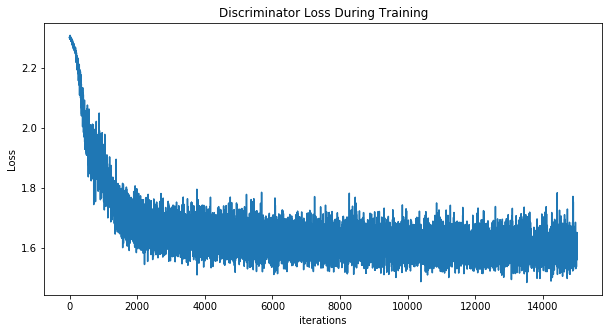

In [15]:
correct = 0
total = 0
pred_ls = []
real_ls = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        real_ls.append([i for i in labels.cpu().numpy()])
        pred_ls.append([i for i in predicted.cpu().numpy()])

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
real_list = [item for sublist in real_ls for item in sublist]
pred_list = [item for sublist in pred_ls for item in sublist]
print('\nThe Confusion Matrix on Validation Set data\n')
print(confusion_matrix(real_list, pred_list))
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

We will now train a neural network which is a little different from the previous model. This network has a Tanh fully connected layer instead of a sigmoid.

In [34]:
class FC2(nn.Module):
    def __init__(self):
        super(FC2, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
        nn.Linear(28*28 * 1 , 50 , bias=True), 
        nn.Tanh(),
        nn.Linear(50,10, bias=True),
        nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x =  x.view(-1, 28*28 * 1)
        return self.main(x)


net = FC2().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
print(net)

FC2(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Softmax()
  )
)


Just like before, we will train the model over 30 epochs.

In [17]:
losses = []
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 2.143
[1,   200] loss: 1.808
[1,   300] loss: 1.712
[1,   400] loss: 1.684
[1,   500] loss: 1.677
[2,   100] loss: 1.656
[2,   200] loss: 1.657
[2,   300] loss: 1.657
[2,   400] loss: 1.647
[2,   500] loss: 1.642
[3,   100] loss: 1.631
[3,   200] loss: 1.635
[3,   300] loss: 1.638
[3,   400] loss: 1.629
[3,   500] loss: 1.633
[4,   100] loss: 1.625
[4,   200] loss: 1.625
[4,   300] loss: 1.624
[4,   400] loss: 1.619
[4,   500] loss: 1.623
[5,   100] loss: 1.624
[5,   200] loss: 1.618
[5,   300] loss: 1.614
[5,   400] loss: 1.611
[5,   500] loss: 1.614
[6,   100] loss: 1.611
[6,   200] loss: 1.609
[6,   300] loss: 1.610
[6,   400] loss: 1.613
[6,   500] loss: 1.610
[7,   100] loss: 1.610
[7,   200] loss: 1.601
[7,   300] loss: 1.606
[7,   400] loss: 1.605
[7,   500] loss: 1.610
[8,   100] loss: 1.604
[8,   200] loss: 1.598
[8,   300] loss: 1.605
[8,   400] loss: 1.602
[8,   500] loss: 1.604
[9,   100] loss: 1.604
[9,   200] loss: 1.594
[9,   300] loss: 1.597
[9,   400] 

Just like before, we will plot the loss function throughout the training process and also approximate the model accuracy on the test data by using a validation set. The predicted accuracy has not changed much from the previous model.

Accuracy of the network on the test images: 86 %

The Confusion Matrix on Validation Set data

[[704  13   5   4  11  18  10  22  11  11]
 [ 14 694   9  29   9  19  14  11   7  10]
 [  6  11 737   8  21   7  27   4   7   9]
 [ 11  28  11 671   7  14  15   8  15  13]
 [  4  13  25   7 662  24  17  13  30   8]
 [  6   5   6  10   6 729   5   9  12  12]
 [  8  16  24   9   5  13 646  10  14   6]
 [ 23  11   8  13   5   7   5 694  15   4]
 [ 11  13  20  14  20  11  15  17 660  33]
 [  9   8   8   8   2   9  13   9  17 709]]


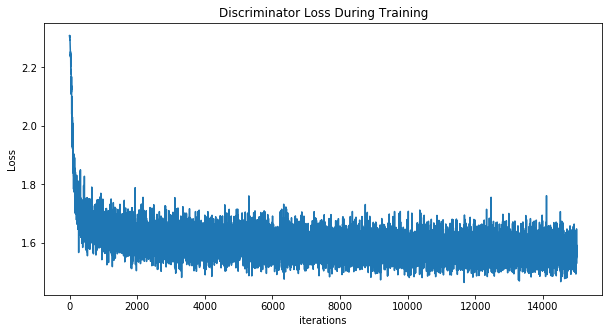

In [18]:
correct = 0
total = 0
pred_ls = []
real_ls = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        real_ls.append([i for i in labels.cpu().numpy()])
        pred_ls.append([i for i in predicted.cpu().numpy()])

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
real_list = [item for sublist in real_ls for item in sublist]
pred_list = [item for sublist in pred_ls for item in sublist]
print('\nThe Confusion Matrix on Validation Set data\n')
print(confusion_matrix(real_list, pred_list))
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

The next two models will be fully connected networks with higher number of neurons. We do not notice that much of a difference in predicted accuracy.

In [35]:
class FC3(nn.Module):
    def __init__(self):
        super(FC3, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
        nn.Linear(28*28 * 1 , 500 , bias=True), 
        nn.Tanh(),
        nn.Linear(500,10, bias=True),
        nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x =  x.view(-1, 28*28 * 1)
        return self.main(x)


net = FC3().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
print(net)

FC3(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=10, bias=True)
    (3): Softmax()
  )
)


In [21]:
losses = []
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 1.617
[1,   200] loss: 1.611
[1,   300] loss: 1.610
[1,   400] loss: 1.614
[1,   500] loss: 1.614
[2,   100] loss: 1.611
[2,   200] loss: 1.615
[2,   300] loss: 1.603
[2,   400] loss: 1.608
[2,   500] loss: 1.606
[3,   100] loss: 1.602
[3,   200] loss: 1.605
[3,   300] loss: 1.604
[3,   400] loss: 1.607
[3,   500] loss: 1.608
[4,   100] loss: 1.598
[4,   200] loss: 1.598
[4,   300] loss: 1.606
[4,   400] loss: 1.603
[4,   500] loss: 1.603
[5,   100] loss: 1.605
[5,   200] loss: 1.593
[5,   300] loss: 1.598
[5,   400] loss: 1.598
[5,   500] loss: 1.601
[6,   100] loss: 1.594
[6,   200] loss: 1.596
[6,   300] loss: 1.603
[6,   400] loss: 1.593
[6,   500] loss: 1.597
[7,   100] loss: 1.591
[7,   200] loss: 1.600
[7,   300] loss: 1.593
[7,   400] loss: 1.595
[7,   500] loss: 1.594
[8,   100] loss: 1.588
[8,   200] loss: 1.599
[8,   300] loss: 1.588
[8,   400] loss: 1.591
[8,   500] loss: 1.595
[9,   100] loss: 1.580
[9,   200] loss: 1.590
[9,   300] loss: 1.592
[9,   400] 

Accuracy of the network on the test images: 86 %

The Confusion Matrix on Validation Set data

[[710  11   1   5  10  17  13  17  13  12]
 [ 12 689   5  25   7  17  27  14   9  11]
 [ 11  10 739   9  16   7  28   4   4   9]
 [  7  31   8 679   9   7  20  10   9  13]
 [  7  13  26   6 663  20  26  10  27   5]
 [  6   7   4  10   5 729  12   8   9  10]
 [ 11  19  20   8   6   9 649   9  12   8]
 [ 26  10   7  11   4   7  10 695  11   4]
 [ 12  12   5  14  29  14  25  15 652  36]
 [ 14   6   6   6   5  11  13   5  12 714]]


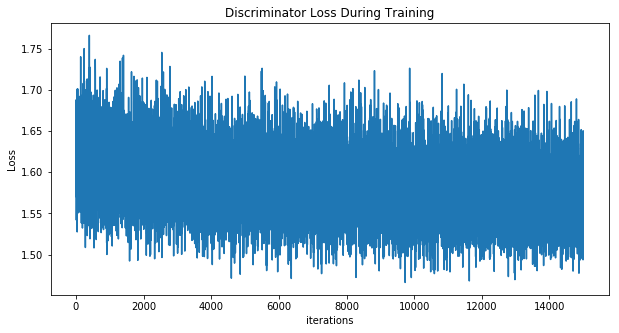

In [22]:
correct = 0
total = 0
pred_ls = []
real_ls = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        real_ls.append([i for i in labels.cpu().numpy()])
        pred_ls.append([i for i in predicted.cpu().numpy()])

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
real_list = [item for sublist in real_ls for item in sublist]
pred_list = [item for sublist in pred_ls for item in sublist]
print('\nThe Confusion Matrix on Validation Set data\n')
print(confusion_matrix(real_list, pred_list))
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [36]:
class FC4(nn.Module):
    def __init__(self):
        super(FC4, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
        nn.Linear(28*28 * 1 , 100 , bias=True), 
        nn.Tanh(),
        nn.Linear(100 ,100 , bias=True), 
        nn.Tanh(),
        nn.Linear(100,10, bias=True),
        nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x =  x.view(-1, 28*28 * 1)
        return self.main(x)


net = FC4().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
print(net)

FC4(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Softmax()
  )
)


In [24]:
losses = []
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 2.243
[1,   200] loss: 1.956
[1,   300] loss: 1.758
[1,   400] loss: 1.691
[1,   500] loss: 1.667
[2,   100] loss: 1.651
[2,   200] loss: 1.649
[2,   300] loss: 1.644
[2,   400] loss: 1.642
[2,   500] loss: 1.636
[3,   100] loss: 1.624
[3,   200] loss: 1.630
[3,   300] loss: 1.629
[3,   400] loss: 1.629
[3,   500] loss: 1.620
[4,   100] loss: 1.628
[4,   200] loss: 1.618
[4,   300] loss: 1.616
[4,   400] loss: 1.607
[4,   500] loss: 1.609
[5,   100] loss: 1.606
[5,   200] loss: 1.608
[5,   300] loss: 1.612
[5,   400] loss: 1.603
[5,   500] loss: 1.616
[6,   100] loss: 1.604
[6,   200] loss: 1.605
[6,   300] loss: 1.602
[6,   400] loss: 1.600
[6,   500] loss: 1.607
[7,   100] loss: 1.595
[7,   200] loss: 1.599
[7,   300] loss: 1.600
[7,   400] loss: 1.600
[7,   500] loss: 1.601
[8,   100] loss: 1.593
[8,   200] loss: 1.601
[8,   300] loss: 1.590
[8,   400] loss: 1.594
[8,   500] loss: 1.596
[9,   100] loss: 1.590
[9,   200] loss: 1.592
[9,   300] loss: 1.593
[9,   400] 

Accuracy of the network on the test images: 86 %

The Confusion Matrix on Validation Set data

[[705  10   2   5   7  12  14  14  23  17]
 [ 11 692   8  26   9  13  27   8  11  11]
 [  8  11 740  11  14   5  28   3   8   9]
 [  7  27  11 679   8   5  20   7  13  16]
 [  7  15  27   7 664  16  21   5  34   7]
 [  6   7   8   9   5 720  14   6  10  15]
 [  6  16  20   8   4   9 659   8  13   8]
 [ 21  11   9  11   6   7  12 685  13  10]
 [  9  12  11  15  22   8  16  13 669  39]
 [ 11   9   4   4   5   8  15   4  18 714]]


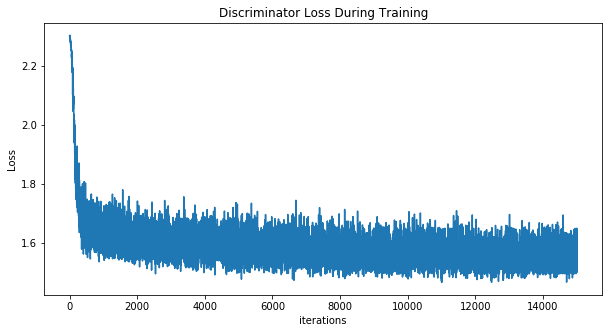

In [25]:
correct = 0
total = 0
pred_ls = []
real_ls = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        real_ls.append([i for i in labels.cpu().numpy()])
        pred_ls.append([i for i in predicted.cpu().numpy()])

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
real_list = [item for sublist in real_ls for item in sublist]
pred_list = [item for sublist in pred_ls for item in sublist]
print('\nThe Confusion Matrix on Validation Set data\n')
print(confusion_matrix(real_list, pred_list))
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Next, we will use a convolutional architecture to be able to improve accuracy. We also will use Batch Normalization layers after each convolutional layer and also a Dropout layer after the final fully connected hidden layer. We will use Leaky RelU instead of RelU because Leaky RelU will provide non zero gradients everywhere and therefore we will be able to better train the model. We will use the above function to initialize the model weights and we will also use the Adam optimization algorithm.

In [37]:
import torch.optim as optim
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.ngpu = 1
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels = 1 , out_channels = 64, kernel_size = 5, stride=1 , padding = 2 , bias = True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride=0),
            nn.Conv2d(in_channels = 64 , out_channels = 64, kernel_size = 5, stride=1 , padding = 2 , bias = True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride=0),
            nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 5, stride=1 , padding = 2 ,bias = True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(in_channels = 128 , out_channels = 128 , kernel_size = 5, stride=1 , padding = 2 , bias = True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.seq2 = nn.Sequential(
            nn.Linear(128 * 7 * 7 , 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256 , 10),
            nn.Softmax(dim = 1)
        )
        

    def forward(self, input):
        x = self.seq1(input)
        x = x.view(-1, 128 * 7 * 7)
        return self.seq2(x)
        
    
criterion = nn.CrossEntropyLoss()   
net = ConvNet().to(device)
net.apply(weights_init)
optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(0.5, 0.999))
print(net)

ConvNet(
  (seq1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1, inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace)
    (11): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [31]:
for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 1.496
[1,   200] loss: 1.495
[1,   300] loss: 1.495
[1,   400] loss: 1.505
[1,   500] loss: 1.498
[2,   100] loss: 1.494
[2,   200] loss: 1.496
[2,   300] loss: 1.502
[2,   400] loss: 1.497
[2,   500] loss: 1.500
[3,   100] loss: 1.500
[3,   200] loss: 1.493
[3,   300] loss: 1.499
[3,   400] loss: 1.499
[3,   500] loss: 1.495
[4,   100] loss: 1.497
[4,   200] loss: 1.500
[4,   300] loss: 1.496
[4,   400] loss: 1.498
[4,   500] loss: 1.498
[5,   100] loss: 1.496
[5,   200] loss: 1.496
[5,   300] loss: 1.498
[5,   400] loss: 1.501
[5,   500] loss: 1.495
[6,   100] loss: 1.498
[6,   200] loss: 1.494
[6,   300] loss: 1.495
[6,   400] loss: 1.495
[6,   500] loss: 1.499
[7,   100] loss: 1.493
[7,   200] loss: 1.493
[7,   300] loss: 1.496
[7,   400] loss: 1.496
[7,   500] loss: 1.498
[8,   100] loss: 1.494
[8,   200] loss: 1.497
[8,   300] loss: 1.493
[8,   400] loss: 1.495
[8,   500] loss: 1.497
[9,   100] loss: 1.496
[9,   200] loss: 1.499
[9,   300] loss: 1.492
[9,   400] 

Accuracy of the network on the test images: 91 %

The Confusion Matrix on Validation Set data

[[745   6   3  10   6   6   4  17  10   2]
 [  9 749   4  13   8   5   6   9  11   2]
 [  5   9 779   0  18   3  10   4   4   5]
 [ 11  13   4 717   7   3   4   7  16  11]
 [  5  10  20   1 721  16   3  14  12   1]
 [  6   7   5   2  19 735   2   9  11   4]
 [  3   8  28   3   9   6 674   6   8   6]
 [  7   5   2   1   7   5   0 749   5   4]
 [  8  18   8   3   9   7   4  15 717  25]
 [  6   2   4   9   5   3   2   4  15 742]]


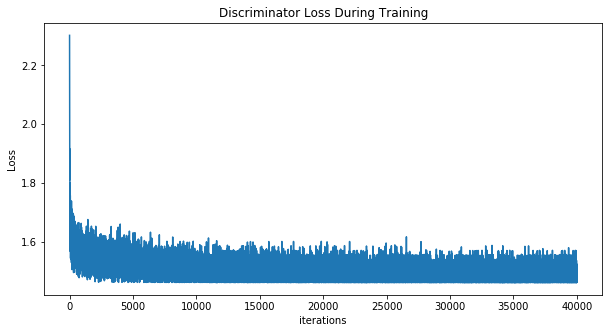

In [32]:
correct = 0
total = 0
pred_ls = []
real_ls = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        real_ls.append([i for i in labels.cpu().numpy()])
        pred_ls.append([i for i in predicted.cpu().numpy()])

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
real_list = [item for sublist in real_ls for item in sublist]
pred_list = [item for sublist in pred_ls for item in sublist]
print('\nThe Confusion Matrix on Validation Set data\n')
print(confusion_matrix(real_list, pred_list))
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()